In [12]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

import warnings
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

In [13]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
    0.1 + i*0.05*scale, np.sqrt((0.02**2+(i*0.1)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

m = 15
data = data_modes(600,m,[1,2,3,4,5],seed = 1)
scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = 8 + scene*0.5

In [14]:
def loss(y,tau,x,p,alpha, data,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = 0
    Nsample = data.shape[0]
    sums += torch.sum(torch.maximum(torch.maximum(-data@x + p*tau - y- alpha,(-1-5*p)*data@x - 4*p*tau - y- alpha),torch.tensor(0.,requires_grad = True)))
    totsum += torch.sum(torch.where(torch.maximum(torch.maximum(-data@x + p*tau - y- alpha,(-1-5*p)*data@x - 4*p*tau - y- alpha),torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))
    sums = (sums/((1-quantile)*Nsample)) + alpha
    return y + torch.tensor(l)*(sums - torch.tensor(target)), torch.mean(-data@x)+p*torch.mean(tau + 5*torch.maximum(-data@x-tau,torch.tensor(0))), totsum/Nsample, sums.detach().numpy()


In [15]:
data = data_modes(600,m,[1,2,3,4,5],seed = 5)
u = lropt.UncertainParameter(m,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x = cp.Variable(m)
tau = cp.Variable()
y = cp.Variable()
p = cp.Parameter()
p.value = scenarios[0][0]
objective = cp.Minimize(y)
constraints = [p >= 0]
constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
constraints += [cp.sum(x)==1, x >= 0]
prob = lropt.RobustProblem(objective, constraints)

target = -0.05
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init = np.eye(m)
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.0001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.0001,batch_percentage = 0.8)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

In [16]:
# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 15, 100), init_A = np.eye(m), init_b = -np.mean(train, axis=0), seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.01,15, 100), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

In [17]:
def plot_coverage_all(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), logscale = True, legend = False, zoom = False):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax, ax1,ax2) = plt.subplots(1, 3, figsize=(23, 3))
    
    ax.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax.fill(np.append(np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")
    ax.fill(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax.set_xlabel("Probability of constraint violation")
    ax.axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
    ax.set_ylabel("Objective value")
    # ax.set_yticks(ticks = [-2e1,0,2e1])
    ax.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax.legend()

    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Decision-Focused set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    if dfs:
        for i in range(5):
            ax1.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax1.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.axvline(x = 0.8, color = "black", linestyle = ":",label = "0.8 Coverage")

    if logscale:
        ax1.set_xscale("log")
    # ax1.set_yticks(ticks = [-2e1,0,2e1])
    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    # ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8)
    if dfs:
        for i in range(5):
            ax2.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Violations']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax2.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Violations']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    # ax2.set_ylim([-0.05,0.25])
    ax2.axvline(x = 0.8, color = "black",linestyle = ":", label = "0.8 Coverage")
    ax2.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    if zoom:
        axins = zoomed_inset_axes(ax2, 6, loc="upper center")
        axins.set_xlim(-0.005, 0.1)
        axins.set_ylim(-0.001,0.035)
        axins.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue")
        axins.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange",alpha = 0.8)
        axins.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
        axins.set_xticks(ticks=[])
        axins.set_yticks(ticks=[])
        mark_inset(ax2, axins, loc1=3, loc2=4, fc="none", ec="0.5")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax2.legend()
    if legend:
        ax2.legend(bbox_to_anchor=(-1.8, -0.6, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 24)
    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    plt.subplots_adjust(left=0.1)
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    plt.show()

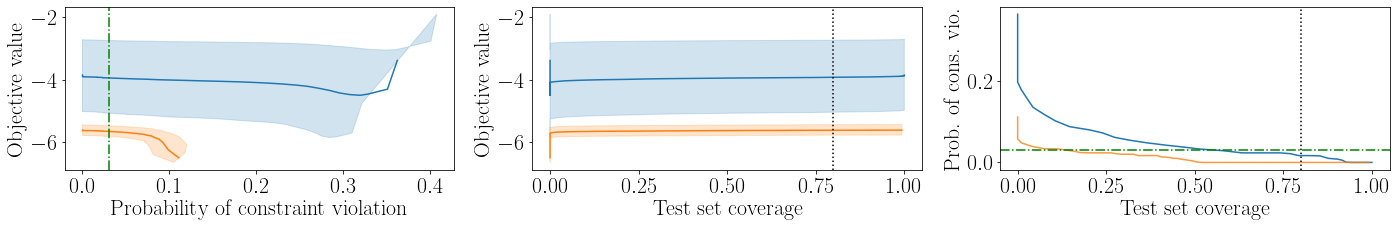

In [18]:
plot_coverage_all(dfgrid,dfgrid2,None, "Port",ind_1=(1,400),ind_2=(1,400), logscale = False,legend = False )

In [8]:

def eval(y,tau,x,p,data,l=10000,quantile = 0.95, target = -0.1):
    y = torch.tensor(y)
    tau = torch.tensor(tau)
    x = torch.tensor(x)
    p = torch.tensor(p)
    data = torch.tensor(data)
    Nsample = data.shape[0]
    totsum = torch.sum(torch.where(torch.maximum(torch.maximum(-data@x + p*tau - y,(-1-5*p)*data@x - 4*p*tau - y),torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))/Nsample
    return totsum


def ret_cvar(y,tau,x,p,data):
    y = torch.tensor(y)
    tau = torch.tensor(tau)
    x = torch.tensor(x)
    p = torch.tensor(p)
    data = torch.tensor(data)    
    return torch.mean(-data@x), torch.mean(tau + 5*torch.maximum(-data@x-tau,torch.tensor(0)))

def cvar_table(result_A,result_b, dfgrid,test, train, value,eps):
    trial1 = np.zeros((num_scenarios,2))
    xvals = np.zeros((num_scenarios,m))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))    
        # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        ret, cvar = ret_cvar(y.value,tau.value,x.value,p.value,test)
        trial1[scene,0] = ret.item()
        trial1[scene,1] = cvar.item()
        xvals[scene] = x.value
    return trial1, xvals

def make_table(result_A,result_b, dfgrid,test, train, value,eps):
    trial1 = np.zeros((num_scenarios,8))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))    
        # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()

        coverage = 0
        for datind in range(test.shape[0]):
            coverage += np.where(np.linalg.norm((1/r_eps)*result_A@test[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )
        coverage_train = 0
        for datind in range(train.shape[0]):
            coverage_train += np.where(np.linalg.norm((1/r_eps)*result_A@train[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )
        ret, cvar = ret_cvar(y.value,tau.value,x.value,p.value,test)
        trial1[scene,0] = np.mean(-test@x.value)+ p.value*np.mean(tau.value + 5*np.maximum(-test@x.value-tau.value,0))
        trial1[scene,1] = eval(y.value,tau.value,x.value,p.value,test).item()
        trial1[scene,2] = eval(y.value,tau.value,x.value,p.value,train).item()
        trial1[scene,3] = coverage/test.shape[0]
        trial1[scene,4] = coverage_train/train.shape[0]
        trial1[scene,5] = newprob.solver_stats.solve_time
        trial1[scene,6] = ret
        trial1[scene,7] = cvar
        # trial1[scene,6] = np.linalg.det(sc.linalg.inv((1/r_eps)*result_A@((1/r_eps)*result_A)))**0.5
    return trial1
def mro(train, test, K = 300, rho = 1):
    vios = np.zeros((num_scenarios))
    vios_1 = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(m,
                                          uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = K))
            # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        objs[scene] = np.mean(-test@x.value)+ p.value*np.mean(tau.value + 5*np.maximum(-test@x.value-tau.value,0))
        vios[scene] = eval(y.value,tau.value,x.value,p.value,test).item()
        vios_1[scene] = eval(y.value,tau.value,x.value,p.value,train).item()
        time[scene] = newprob.solver_stats.solve_time
    return vios, vios_1, objs, time

In [35]:
Ar_saved = np.zeros((100,m,m))
br_saved = np.zeros((100,m))
# As_saved = np.zeros((100,15,15))
# bs_saved = np.zeros((100,15))
reshaped_table = np.zeros((1,24))
standard_table = np.zeros((1,24))
for experiment in range(20):
    np.random.seed(experiment)
    data = data_modes(600,m,[1,2,3],seed = experiment)
    # Formulate uncertainty set
    u = lropt.UncertainParameter(m,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        data=data, loss = loss))
    # Formulate the Robust Problem
    x = cp.Variable(m)
    tau = cp.Variable()
    y = cp.Variable()
    p = cp.Parameter()
    p.value = scenarios[0][0]
    objective = cp.Minimize(y)
    constraints = [p >= 0]
    constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
    constraints += [cp.sum(x)==1, x >= 0]
    prob = lropt.RobustProblem(objective, constraints)

    target = -0.05
    test_p = 0.5
    s = 5
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
    init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    init_bval = -init@np.mean(train, axis=0)
    # Train A and b
    result1 = prob.train(lr = 0.001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.1,batch_percentage = 0.8)
    df1 = result1.df
    A_fin = result1.A
    b_fin = result1.b
    Ar_saved[experiment,:] = A_fin
    br_saved[experiment,:] = b_fin

    # Grid search epsilon
    result4 = prob.grid(epslst = np.linspace(1.6, 1.8, 200), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    result5 = prob.grid(epslst = np.linspace(0.2,0.42, 200), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid2 = result5.df

    r_t = make_table(A_fin, b_fin, dfgrid2,test,train,0.024, eps = 0)
    r_t1 = make_table(A_fin, b_fin, dfgrid2,test,train,0.02, eps = 0)
    r_t2 = make_table(A_fin, b_fin, dfgrid2,test,train,0.01, eps = 0)
    r_t = np.hstack((r_t, r_t1, r_t2))
    
    reshaped_table = np.vstack((reshaped_table, r_t))

    s_t = make_table(init, init_bval, dfgrid,test, train,0.024, eps = 0)
    s_t1 = make_table(init, init_bval, dfgrid,test, train,0.20, eps = 0)
    s_t2 = make_table(init, init_bval, dfgrid,test, train,0.022, eps = 0)
    s_t = np.hstack((s_t, s_t1, s_t2))
    standard_table = np.vstack((standard_table, s_t))
    pd.DataFrame(standard_table).to_csv("standard_table30.csv")
    pd.DataFrame(reshaped_table).to_csv("reshaped_table30.csv")
    print("standard", s_t)
    print("reshaped", r_t)
    np.save("Ar_saved30.npy", Ar_saved)
    # np.save("As_saved.npy", As_saved)
    np.save("br_saved30.npy", br_saved)
    # np.save("bs_saved.npy", bs_saved)
# standard_table = pd.read_csv("standard_table_1.csv").iloc[:,1:]
# reshaped_table = pd.read_csv("reshaped_table_1.csv").iloc[:,1:]
# standard_table = standard_table.values
# reshaped_table = reshaped_table.values
# pd.DataFrame(standard_table).to_csv("standard_table_1.csv")
# pd.DataFrame(reshaped_table).to_csv("reshaped_table_1.csv")
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

AssertionError: Arguments of cp.maximum must be affine

In [45]:
targets = [0.03,0,0.01]
def printresults(table,targets):
  for i in range(3):
    print("test_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*8 + 1].reshape(-1, 5), axis=1)))
    print("train_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*8 + 2].reshape(-1, 5), axis=1)))
    print("test_obj_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*8].reshape(-1, 5), axis=1)))
    print("train_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*8+4].reshape(-1, 5), axis=1)))
    print("test_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*8+3].reshape(-1, 5), axis=1)))
    print("returns " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*8+6].reshape(-1, 5), axis=1)))
    print("cvar " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*8+7].reshape(-1, 5), axis=1)))
    print("solve time " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*8+5].reshape(-1, 5), axis=1)))
    print(" ")

In [46]:
printresults(reshaped_table,targets)

test_vio_target 0.03:  0.044666666593402626
train_vio_target 0.03:  0.03999999945983291
test_obj_target 0.03:  -7.242193140913893
train_coverage 0.03:  0.0
test_coverage 0.03:  0.0
solve time 0.03:  0.00317697293
 
test_vio_target 0:  -0.5541886957732995
train_vio_target 0:  -6.6369048145144856
test_obj_target 0:  -1.7136993677249546
train_coverage 0:  0.03456666646525264
test_coverage 0:  0.038633333276957275
solve time 0:  0.0
 
test_vio_target 0.01:  0.0031902980100000007
train_vio_target 0.01:  -1.5711387312584888
test_obj_target 0.01:  0.0
train_coverage 0.01:  -5.061268355827577
test_coverage 0.01:  -0.5081069140167012
solve time 0.01:  0.025966666676104068
 


In [47]:
printresults(standard_table,targets)

test_vio_target 0.03:  0.03563333349302411
train_vio_target 0.03:  0.03586666665971279
test_obj_target 0.03:  -0.8020991386022658
train_coverage 0.03:  0.0
test_coverage 0.03:  0.0
solve time 0.03:  0.0035171253800000005
 
test_vio_target 0:  -0.05470888212689051
train_vio_target 0:  -0.8301095045309544
test_obj_target 0:  -0.25530271451901
train_coverage 0:  0.05500000026077032
test_coverage 0:  0.05630000066012144
solve time 0:  0.0
 
test_vio_target 0.01:  0.0035232583800000002
train_vio_target 0.01:  -0.2591084746044104
test_obj_target 0.01:  0.0
train_coverage 0.01:  -0.7986331594174495
test_coverage 0.01:  -0.057135697697740864
solve time 0.01:  0.032599999867379666
 


In [97]:
np.mean(np.mean(standard_table[:,13].reshape(-1, 5), axis=1) >= 0.05)

0.05

In [96]:
np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1) >= 0.05)

0.0

In [11]:
totalvios = np.zeros((num_scenarios*20,10))
totalvios_train =  np.zeros((num_scenarios*20,10))
totalobjs = np.zeros((num_scenarios*20,10))
totaltime = np.zeros((num_scenarios*20,10))
epsrange = np.linspace(2.9,3.5,10)
for experiment in range(20):
    print(experiment)
    np.random.seed(experiment)
    data = data_modes(600,m,[1,2,3,4,5],seed = experiment)
    train, test = train_test_split(data, test_size=int(data.shape[0]*0.5), random_state=5)
    ind = 0
    for eps in epsrange:
        vios, vios1, objs, time = mro(train,test, K = 300, rho = eps)
        print(vios,objs)
        totalvios[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios 
        totalvios_train[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios1
        totalobjs[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = objs 
        totaltime[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = time
        ind += 1
        np.save("totalvios30.npy", totalvios)
        np.save("totalvios_train30.npy", totalvios_train)
        np.save("totalobjs30.npy", totalobjs)
        np.save("totaltime30.npy", totaltime)

0
[0.03666667 0.03666667 0.03666667 0.03666667 0.03666667] [ -9.79154023 -10.22711152 -10.66299621 -11.09909538 -11.53554982]
[0.03666667 0.03666667 0.03666667 0.03666667 0.03666667] [ -9.77812212 -10.21321822 -10.64865552 -11.08448627 -11.52062418]
[0.03666667 0.03666667 0.03666667 0.03666667 0.03666667] [ -9.76507642 -10.19981391 -10.63500387 -11.07053842 -11.50637942]
[0.03666667 0.03666667 0.03666667 0.03666667 0.03666667] [ -9.75252328 -10.18704451 -10.62195957 -11.05732928 -11.49324716]
[0.03333334 0.03333334 0.03333334 0.03333334 0.03333334] [ -9.74056325 -10.17483551 -10.60969201 -11.04506565 -11.48074748]
[0.03333334 0.03333334 0.03333334 0.03333334 0.03333334] [ -9.72911703 -10.16339475 -10.59818947 -11.03334341 -11.46878171]
[0.03333334 0.03333334 0.03333334 0.03333334 0.03333334] [ -9.71839144 -10.1525819  -10.58718134 -11.02210661 -11.45731069]
[0.03333334 0.03333334 0.03333334 0.03333334 0.03333334] [ -9.70822231 -10.14223226 -10.57661827 -11.01132531 -11.44620168]
[0.033

In [24]:
np.mean(totalvios[:,7]),np.mean(totalobjs[:,7]), np.mean(totaltime[:,7])

(0.030366666931658983, -11.150178215560468, 0.19145121375)

In [20]:
print(np.mean(np.mean(totalvios[:,7].reshape(-1, 5), axis=1) > 0.05))

0.0
